# Add a component: A temperature field

In [1]:
from dask.distributed import Client

client = Client(n_workers=3, threads_per_worker=1, memory_limit=1e9)
client

Client Scheduler: tcp://127.0.0.1:52886 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 3.00 GB


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d

In [3]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
    
    def get_sizes(self):
        return self.length_x, self.length_y
        
    def normalize_positions(self, x, y):
        return np.mod(x, self.length_x), np.mod(y, self.length_y)

In [4]:
class Field:
    def __init__(self, Nx=10, Ny=10, space=None, rng=None):
        self.space = space
        self.rng = rng
        self.Nx = Nx
        self.Ny = Ny
        self.set_up_space()
        self.set_up_field()
        self.set_up_interpolator()
        
    def set_up_space(self):
        self.length_x, self.length_y = self.space.get_sizes().result()
        self.x = np.linspace(0, self.length_x, self.Nx)
        self.y = np.linspace(0, self.length_y, self.Ny)
        
    def set_up_field(self):
        self.field = 5 + 10 * rng.normal(size=(self.Ny, self.Nx)).result()
    
    def set_up_interpolator(self):
        self.interpolator = interp2d(
            x=self.x, y=self.y, z=self.field
        )
        
    def get_field_at(self, x, y):
        x = list(x)
        y = list(y)
        return np.array(list(map(self.interpolator, x, y)))

Each particle calls the spatial domain.  In distributed mode, we'll have to make sure that we get the `.result()` from the [`Future` objects](https://docs.python.org/3/library/concurrent.futures.html#future-objects) returned when calling methods on actors.

In [5]:
class Particles:
    def __init__(
        self,
        rng=np.random.RandomState(),
        space=PeriodicSpace(),
        field=None,
        x=None, y=None,
        step_length=0.5
    ):
        self.rng = rng
        self.space = space
        self.field = field
        self.x, self.y = x, y
        self.step_length = step_length
        self.steps_done = 0

    def move(self):
        self.x += self.step_length * self.rng.normal(size=self.x.shape).result()
        self.y += self.step_length * self.rng.normal(size=self.y.shape).result()
        
        self.x, self.y = self.space.normalize_positions(self.x, self.y).result()
        
        self.steps_done += 1

    def center_of_mass(self):
        return self.x.mean(), self.y.mean()
    
    def moment_of_inertia(self):
        return self.x.var() + self.y.var()
    
    def get_field(self):
        return self.field.get_field_at(self.x, self.y).result().squeeze()
    
    def mean_field(self):
        return self.get_field().mean()
    
    def var_field(self):
        return self.get_field().var()

    def diagnostics(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        mf = self.mean_field()
        vf = self.var_field()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi,
                "mean_field": mf,
                "var_field": vf
            },
            index=[self.steps_done, ],        
        )
    
    def positions(self):
        return pd.DataFrame(
            {
                "x": self.x,
                "y": self.y,
                "field": self.get_field()
            }
        )

## Submit space, rng and group of particles to the cluster

In [6]:
space = client.submit(
    PeriodicSpace,
    length_x=10,
    length_y=20,
    actor=True,
    pure=False
).result()

In [7]:
rng = client.submit(
    np.random.RandomState, actor=True, pure=False
).result()

In [8]:
field = client.submit(
    Field,
    Nx=25, Ny=10, rng=rng, space=space,
    actor=True, pure=False
).result()

In [9]:
field.get_field_at(np.arange(5), np.arange(5)).result()

array([[23.23893378],
       [ 0.409335  ],
       [10.35416588],
       [ 5.70853066],
       [ 3.50048184]])

In [10]:
length_x, length_y = space.get_sizes().result()

particles = client.submit(
    Particles, space=space, rng=rng, field=field,
    x=np.ones((10_000, )) * length_x / 2.0,
    y=np.ones((10_000, )) * length_y / 2.0,
    actor=True, pure=False
).result()

## Plot initial positions

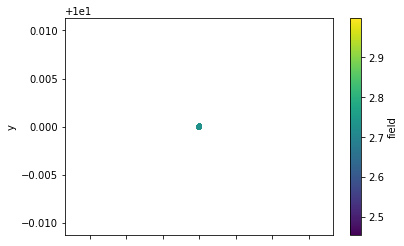

In [11]:
particles.positions().result().plot.scatter(x="x", y="y", c="field", colormap="viridis");

In [12]:
particles.diagnostics().result()

,center_of_mass_x,center_of_mass_y,moment_of_inertia,mean_field,var_field
0,5.0,10.0,0.0,2.726605,0.0


## Run the main loop

In [13]:
diags = particles.diagnostics().result()
    
for step in range(1, 100):
    particles.move().result()

    diags = diags.append(
        particles.diagnostics().result()
    )

## Plot data

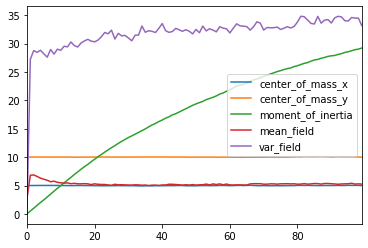

In [14]:
diags.plot();

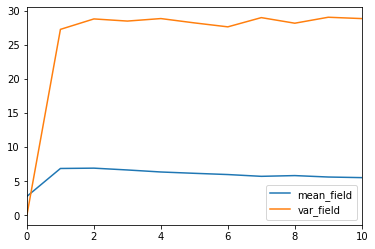

In [15]:
diags[["mean_field", "var_field"]].loc[:10].plot();

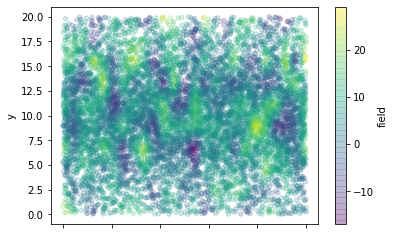

In [16]:
particles.positions().result().plot.scatter(x="x", y="y", c="field", colormap="viridis", alpha=0.2);